In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd

data_path = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
sys.path.append(data_path)
model_path = os.path.abspath(os.path.join(os.getcwd(), "..", "models"))
sys.path.append(model_path)

from malaria_model_1 import MalariaNet
from data_loader import create_dataloaders

Used data path: C:\ZHAW_local\semester_6_local\DS in Health\project_work\data


In [2]:
# === Load model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MalariaNet(num_classes=2).to(device)
model_file = os.path.join(model_path, "best_malaria_model_attmy8cd_epoch7.pth")
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

# === Load test data ===
_, _, test_loader = create_dataloaders(aug_level="none", batch_size=32)

# === Collect predictions and labels ===
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)[:, 1]  # Only probability for class 1 (Parasitized)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)


In [3]:
thresholds = np.linspace(0.0, 1.0, 101)
fn_list = []
fp_list = []
accuracy_list = []

for t in thresholds:
    preds = (all_probs >= t).astype(int)
    cm = confusion_matrix(all_labels, preds)
    tn, fp, fn, tp = cm.ravel()
    
    fn_list.append(fn)
    fp_list.append(fp)
    accuracy_list.append((tp + tn) / (tp + tn + fp + fn))

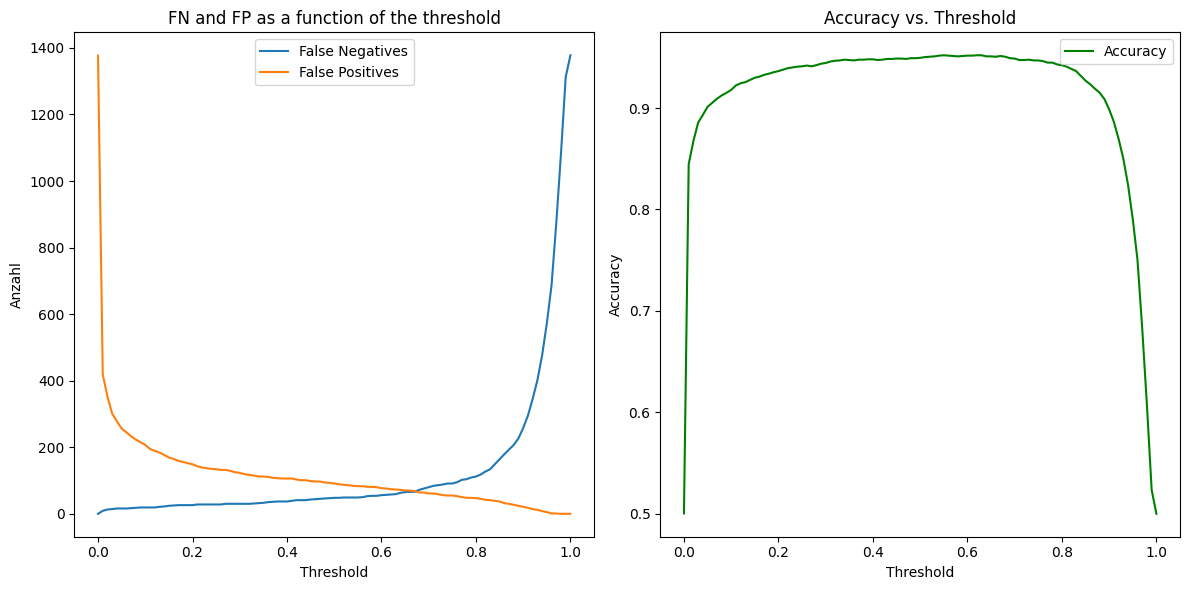

In [4]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(thresholds, fn_list, label="False Negatives")
plt.plot(thresholds, fp_list, label="False Positives")
plt.xlabel("Threshold")
plt.ylabel("Anzahl")
plt.title("FN and FP as a function of the threshold")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(thresholds, accuracy_list, label="Accuracy", color="green")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Threshold")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
thresholds_to_check = [0.5, 0.4, 0.35, 0.3, 0.25, 0.2, 0.1]
results = []

prev_fp = None
prev_fn = None

for threshold in thresholds_to_check:
    preds = (all_probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(all_labels, preds).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # Delta-Werte berechnen (ab 2. Zeile)
    delta_fp = fp - prev_fp if prev_fp is not None else None
    delta_fn = fn - prev_fn if prev_fn is not None else None
    cost_benefit = (delta_fp / -delta_fn) if (delta_fp is not None and delta_fn != 0) else None

    results.append({
        "Threshold": threshold,
        "False Positives": fp,
        "False Negatives": fn,
        "Accuracy": round(accuracy, 4),
        "delta_FP": delta_fp,
        "delta_FN": delta_fn,
        "delta_FP/-delta_FN": round(cost_benefit, 2) if cost_benefit is not None else None
    })

    prev_fp = fp
    prev_fn = fn

df_results = pd.DataFrame(results)
df_results

,Threshold,False Positives,False Negatives,Accuracy,delta_FP,delta_FN,delta_FP/-delta_FN
0,0.50,91,48,0.9495,NaN,NaN,NaN
1,0.40,106,37,0.9481,15.0,-11.0,1.36
2,0.35,112,33,0.9474,6.0,-4.0,1.50
3,0.30,123,30,0.9445,11.0,-3.0,3.67
4,0.25,134,28,0.9412,11.0,-2.0,5.50
5,0.20,149,26,0.9365,15.0,-2.0,7.50
6,0.10,207,19,0.9180,58.0,-7.0,8.29


By lowering the threshold of the base model from 0.50 to 0.35, we were able to reduce the number of **false negatives (FN) from 48 to 33**, which is highly relevant in the context of malaria detection, where missing an infected case can have life-threatening consequences.

This improvement comes at the cost of increasing **false positives (FP) from 91 to 112**, but this trade-off is acceptable given that a false alarm is less critical than a missed infection. The cost-benefit ratio (ΔFP / -ΔFN) is 1.50, indicating a relatively efficient gain in sensitivity without a disproportionate increase in false positives.